CPLEX Modeling for Python: DOCplex
==================================

Welcome to the IBM Decision Optimization CPLEX Modeling for Python.

With this library (available via github or pypi), you can easily and quickly model your problems and solve them using IBM CPLEX Optimizers.

Optimizers can be called in two ways:

* Local installation of IBM ILOG CPLEX Optimization Studio v12.6.2.
* Solving with the [IBM Decision Optimization on Cloud](http://www.ibm.com/software/analytics/docloud/) service. You can get a free 30-days trail [here](https://developer.ibm.com/docloud/try-docloud-free/).

Installation of DOCplex is easy. Just use `pip`.

In [1]:
!pip install docplex

Cleaning up...


The Equitable Coach Problem
===========================


Get the data
--------------
Data that describes the game (number of periods, players on field, potential positions and formations) never changes and is thus hard-coded.
The player information instead is loaded dynamically since that may change.

In [2]:
game_length = 20
periods = range(game_length)
nplayers = 7 # number of players on the field

formation = "2-3-1"
positions = ["G", "D", "M", "S"]
formations = {"3-2-1": {"G": 1, "D": 3, "M": 2, "S": 1},
              "3-1-2": {"G": 1, "D": 3, "M": 1, "S": 2},
              "2-3-1": {"G": 1, "D": 2, "M": 3, "S": 1},
              "2-2-2": {"G": 1, "D": 2, "M": 2, "S": 2},
          }
formation = formations[formation]

Load list of players.

In [3]:
pos_for_player = {
  "Josh":   ["S", "M"],
  "Simon":  ["S"],
  "Jordy":  ["S"],
  "Chris":  ["M", "D"],
  "Andy":   ["M"],
  "Richie": ["M", "D"],
  "Tritto": ["D"],
  "Guy":    ["D"],
  "Neil":   ["M"],
  "Justin": ["M"],
  "Steve":  ["D"],
  "Cory":   ["G"]
}
players = pos_for_player.keys()
# compute for each position, which players can play it
players_on_pos = {pos: [name for name in players if pos in pos_for_player[name]] for pos in positions}

Initialize the model
--------------------

Prepare for local (`api_key = None`) or cloud solve.

In [4]:
from docplex.mp.model import Model
from docplex.mp.context import DOcloudContext

url = 'https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1'
api_key = None
context = DOcloudContext(url, api_key = None)
m = Model("ECP", docloud_context=context)

Create the variables
--------------------

The method `m.continues_var_dict` gets a list (in fact any iterable) of keys and returns a dictionary

    key -> variable.
    
You can give bounds and a name where the string representation of the key will be appended.

In [5]:
eplus = m.continuous_var_dict(players, lb=0.0, name="eplus")
eminus = m.continuous_var_dict(players, lb=0.0, name="eminus")

We build a datastructure

    x[period][player][position]
    
that has the variable that indicated if some player plays on some position in some period.

In [6]:
x = {}
for period in periods:
    x[period] = {}
    
    # iterate of the player and their respective list of positions.
    for (player, poslist) in pos_for_player.items():
        
        # we can give a function with one argument to construct the name of the variable
        x_name_func = lambda pos: "x%d%s%s" % (period, player, pos)
        
        x[period][player] = m.binary_var_dict(poslist, name=x_name_func)

Build the objective function
----------------------------

In [7]:
obj = m.sum(eplus[player] + eminus[player] for player in players)
m.minimize(obj)

Build the constraints
---------------------

Ensure that each player plays on at most one position per time

In [8]:
for player in players:
    for period in periods:
        m.add_constraint( m.sum(x[period][player]) <= 1 )

Ensure that we have the right number of players on each position

In [9]:
for pos in positions:
    for period in periods:
        cons = m.sum(x[period][player][pos] for player in players_on_pos[pos]) == formation[pos]
        m.add_constraint(cons)

Calculate the minutes over/below the average

In [10]:
avg = game_length * nplayers / float(len(players))

for player in players:
    periods_played = m.sum(m.sum(x[p][player]) for p in periods)
    m.add_constraint(periods_played - avg == eplus[player] - eminus[player])

What do we know about the model now?

In [11]:
m.print_information()

Model: ECP
 - number of variables: 324
 -   binary=300, integer=0, continuous=24
 - number of constraints: 332
 -   LE=240, EQ=92, GE=0, RNG=0
 - parameters : defaults


Solve the model!
-------------------------

In [12]:
if not m.solve():
    print("*** Problem has no solution")
else:
    print("* model solved as function with objective: %g" % m.objective_value)

* model solved as function with objective: 17.3333


Display the solution
-----------------------
In order to access parts of the solution, just convert a variable to `float` to get its value.

We visualize the solution in 3 ways:
* Print for each player how much he played in which position
* Use ASCII arts to show the formation and substitutions for each period
* Use matplotlib to show the formation in each period

Show for each player how long he played in which position.

In [13]:
for player in players:
    played_total = 0.0
    for pos in pos_for_player[player]:
        played_on_pos = 0.0
        for p in range(game_length):
            played_on_pos += int(float(x[p][player][pos]))
            played_total += int(float(x[p][player][pos]))
        if played_on_pos > 0:
            print("%-6s played %2d minutes as %s" % (player, played_on_pos, pos))

Simon  played  9 minutes as S
Justin played 11 minutes as M
Josh   played 11 minutes as M
Andy   played 11 minutes as M
Guy    played 11 minutes as D
Tritto played 12 minutes as D
Neil   played 11 minutes as M
Jordy  played 11 minutes as S
Steve  played 11 minutes as D
Chris  played  9 minutes as M
Chris  played  2 minutes as D
Cory   played 20 minutes as G
Richie played  7 minutes as M
Richie played  4 minutes as D


Display subsitutions and formation grid for each period using ASCII arts.

In [14]:
last = ''
for player in players:
    last += '0'
for m in range(game_length):
    state = ''
    for player in players:
        current = '0'
        for pos in pos_for_player[player]:
            if float(x[m][player][pos]) > 0.5:
                current = pos
        state = state + current
    subst = ''
    if m > 0:
        for i in range(len(state)):
            if not state[i] == last[i]:
                if last[i] == '0':
                    subst = subst + ' ->' + players[i] + '(' + state[i] + ')'
                elif state[i] == '0':
                    subst = subst + ' <-' + players[i]
                else:
                    subst = subst + ' ' + players[i] + '(' + last[i] + '->' + state[i] + ')'
    print 'Period', m, subst
    for pos in positions:
        thatpos = []
        for i in range(len(state)):
            if state[i] == pos:
                thatpos.append(players[i])
        if len(thatpos) == 1:
            print('\t        %-6s        ' % (thatpos[0]))
        elif len(thatpos) == 2:
            print('\t   %-6s  %-6s   ' % (thatpos[0], thatpos[1]))
        elif len(thatpos) == 3:
            print('\t%-6s  %-6s %-6s' % (thatpos[0], thatpos[1], thatpos[2]))
    last = state
    

Period 0 
	        Cory          
	   Guy     Steve    
	Justin  Josh   Neil  
	        Simon         
Period 1  <-Guy ->Tritto(D)
	        Cory          
	   Tritto  Steve    
	Justin  Josh   Neil  
	        Simon         
Period 2  <-Neil ->Richie(M)
	        Cory          
	   Tritto  Steve    
	Justin  Josh   Richie
	        Simon         
Period 3  <-Justin <-Josh ->Andy(M) ->Guy(D) <-Tritto ->Neil(M)
	        Cory          
	   Guy     Steve    
	Andy    Neil   Richie
	        Simon         
Period 4  ->Justin(M) ->Josh(M) <-Andy <-Guy ->Tritto(D) <-Neil
	        Cory          
	   Tritto  Steve    
	Justin  Josh   Richie
	        Simon         
Period 5  <-Simon ->Guy(D) <-Tritto ->Jordy(S) <-Steve ->Chris(M) Richie(M->D)
	        Cory          
	   Guy     Richie   
	Justin  Josh   Chris 
	        Jordy         
Period 6  <-Justin ->Andy(M) ->Tritto(D) <-Richie
	        Cory          
	   Guy     Tritto   
	Josh    Andy   Chris 
	        Jordy         
Period 7  <-Guy ->Steve(D

Create a list that holds the formation (by position) for each period.

In [15]:
onfield = []
for i in range(game_length):
    bypos = dict()
    for pos in positions:
        bypos[pos] = []
    for player in players:
        for pos in pos_for_player[player]:
            if float(x[i][player][pos]) > 0.5:
                bypos[pos].append(player)
    onfield.append(bypos)

Render the formation in each period as graphics.

Creating graphics . . . . . . . . . . . . . . . . . . . . ok


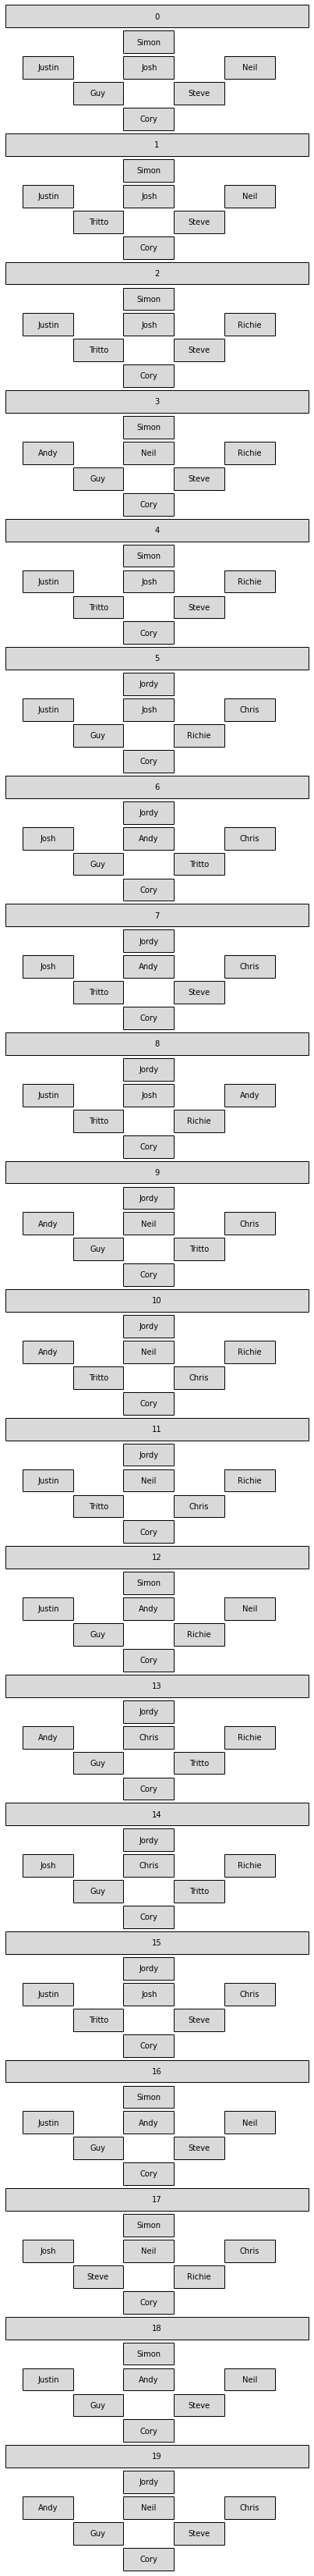

In [16]:
%matplotlib inline
import matplotlib.pyplot as plot
from matplotlib.widgets import Button

class FormationView:
    def __init__(self, onfield):
        self._onfield = onfield
        self._scale = 2.0
        y = 1.0
        ydelta = 1.0 / (len(onfield) + 1)
        print 'Creating graphics',
        for i in range(len(onfield)):
            print '.',
            y = y - ydelta
            self.show_period(i, onfield[i], y, ydelta)
        print 'ok'
    def show_period(self, period, onfield, y, ydelta):
        s = self._scale * 6.0
        Button(plot.axes([0, s * (y + ydelta * 0.85), 0.9, self._scale * 0.05]), str(period))
        self.doline(s * (y + ydelta * 0.05), onfield['G'])
        self.doline(s * (y + ydelta * 0.25), onfield['D'])
        self.doline(s * (y + ydelta * 0.45), onfield['M'])
        self.doline(s * (y + ydelta * 0.65), onfield['S'])
        
    def doline(self, y, names):
        w = self._scale * 0.075
        h = self._scale * 0.05
        m = 0.05
        if (len(names) == 1):
            ax = plot.axes([m + 0.3, y, w, h])
            b = Button(ax, names[0])
        elif (len(names) == 2):
            for i in range(2):
                ax = plot.axes([m + 0.15 + 0.3 * i, y, w, h])
                b = Button(ax, names[i])
        elif (len(names) == 3):
            for i in range(3):
                ax = plot.axes([m + 0.3 * i, y, w, h])
                b = Button(ax, names[i])

FormationView(onfield)
plot.show()